In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as ticker
import scipy.stats
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *

plt.style.use('../peptidome.mplstyle')
from lib.plotting import model_labels as labels


import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import json
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
from matplotlib.ticker import MaxNLocator

Matplotlib is building the font cache; this may take a moment.


## Figure 4 Code
For the original analayses and data derivation see `https://github.com/andim/peptidome/tree/master/code/nndist`, especially `response_vs_distance.ipynb` and `https://github.com/andim/peptidome/blob/master/code/maxent/`, especially `malaria_analysis.ipynb`.
For the likelihood profiles, see `https://github.com/andim/peptidome/blob/master/code/likelihoodprofile/likelihood-maxent.ipynb`

In [3]:
datadir = '../data/generated_data'
figdatadir ='../data/Figure Data'

#### IEDB Hamming distance distribution


In [3]:
response_df = pd.read_csv(f'{figdatadir}/response_vs_distance.csv')

In [4]:
response_df

,nndist,mean,count
0,0,0.045455,22
1,1,0.261682,107
2,2,0.256919,2421
3,3,0.199430,3510


In [5]:
ps = np.array(response_df['mean'])
ns = np.array(response_df['count'])

In [6]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((np.int64(0), np.int64(1)), np.float64(0.11207735267750049)),
 ((np.int64(0), np.int64(2)), np.float64(0.11207735267750049)),
 ((np.int64(0), np.int64(3)), np.float64(0.19839264331892242)),
 ((np.int64(1), np.int64(2)), np.float64(0.912144377818153)),
 ((np.int64(1), np.int64(3)), np.float64(0.21434256387314266)),
 ((np.int64(2), np.int64(3)), np.float64(1.0254004088381143e-06))]

In [7]:
response_df['observed'] = response_df.apply(lambda row: row['mean']*row['count'],axis=1)

In [8]:
response_df

,nndist,mean,count,observed
0,0,0.045455,22,1.0
1,1,0.261682,107,28.0
2,2,0.256919,2421,622.0
3,3,0.199430,3510,700.0


In [9]:
close = response_df[response_df['nndist']!=3].sum()[['count', 'observed']]
far = response_df[response_df['nndist']==3].sum()[['count', 'observed']]

In [10]:
close

count       2550.0
observed     651.0
dtype: float64

In [11]:
100*close['observed']/close['count']

np.float64(25.529411764705888)

In [12]:
far

count       3510.0
observed     700.0
dtype: float64

In [13]:
100*far['observed']/far['count']

np.float64(19.943019943019937)

In [14]:
arg1 = np.array([close['observed'],far['observed']])
arg2 = np.array([close['count'],far['count']])

In [15]:

stat, pval = statsmodels.stats.proportion.proportions_ztest(arg1,arg2)


In [16]:
pval

np.float64(2.4931691571729094e-07)

### Malaria +/- Epitopes vs. Background PDF and Hamming Distances

In [17]:
with open(f'{figdatadir}/malaria_pdf.json','r') as ff:
    density_dict = json.load(ff)

In [18]:
density_dict.keys()

dict_keys(['Human Peptidome', 'Malaria Peptidome', 'Malaria Epitopes', 'Malaria Epitopes (-)'])

In [19]:
order = ['Human Peptidome', 'Malaria Peptidome', 'Malaria Epitopes (-)', 'Malaria Epitopes']
source_mapper = {
    'Malaria Peptidome': 'Malaria Peptides',
    'Malaria Epitopes (-)': 'Non-Immunogenic Epitopes',
    'Malaria Epitopes (+)': 'Immunogenic Epitopes',

}

In [20]:
distances_df = pd.read_csv(f'{figdatadir}/malaria_distances.csv')
distances_df['source'] = distances_df['source'].apply(source_mapper.get)

In [21]:
distances_df

,Unnamed: 0,distance_bin,source,value,distance
0,0,0,Malaria Peptides,0.003250,0
1,1,1,Malaria Peptides,0.022360,1
2,2,2,Malaria Peptides,0.379320,2
3,3,3,Malaria Peptides,0.595070,3+
4,4,0,Non-Immunogenic Epitopes,0.000000,0
5,5,1,Non-Immunogenic Epitopes,0.055556,1
6,6,2,Non-Immunogenic Epitopes,0.333333,2
7,7,3,Non-Immunogenic Epitopes,0.611111,3+
8,8,0,Immunogenic Epitopes,0.000000,0
9,9,1,Immunogenic Epitopes,0.023810,1


In [22]:
source_mapper.values()

dict_values(['Malaria Peptides', 'Non-Immunogenic Epitopes', 'Immunogenic Epitopes'])

In [23]:
rows = []
for i, source in enumerate(distances_df['source'].unique()):
    x = np.array(range(2))
    y = np.squeeze(distances_df[(distances_df['source']==source)&(distances_df['distance']=='3+')]['value'])
    rows.append({
        'source': source,
        'distance': '<=2',
        'value': 1-y,
    })
    rows.append({
        'source': source,
        'distance': '>3',
        'value': y

    })
collapsed_df = pd.DataFrame(data=rows)

In [24]:
total_df = collapsed_df.groupby(by=['source']).sum()[['value']]

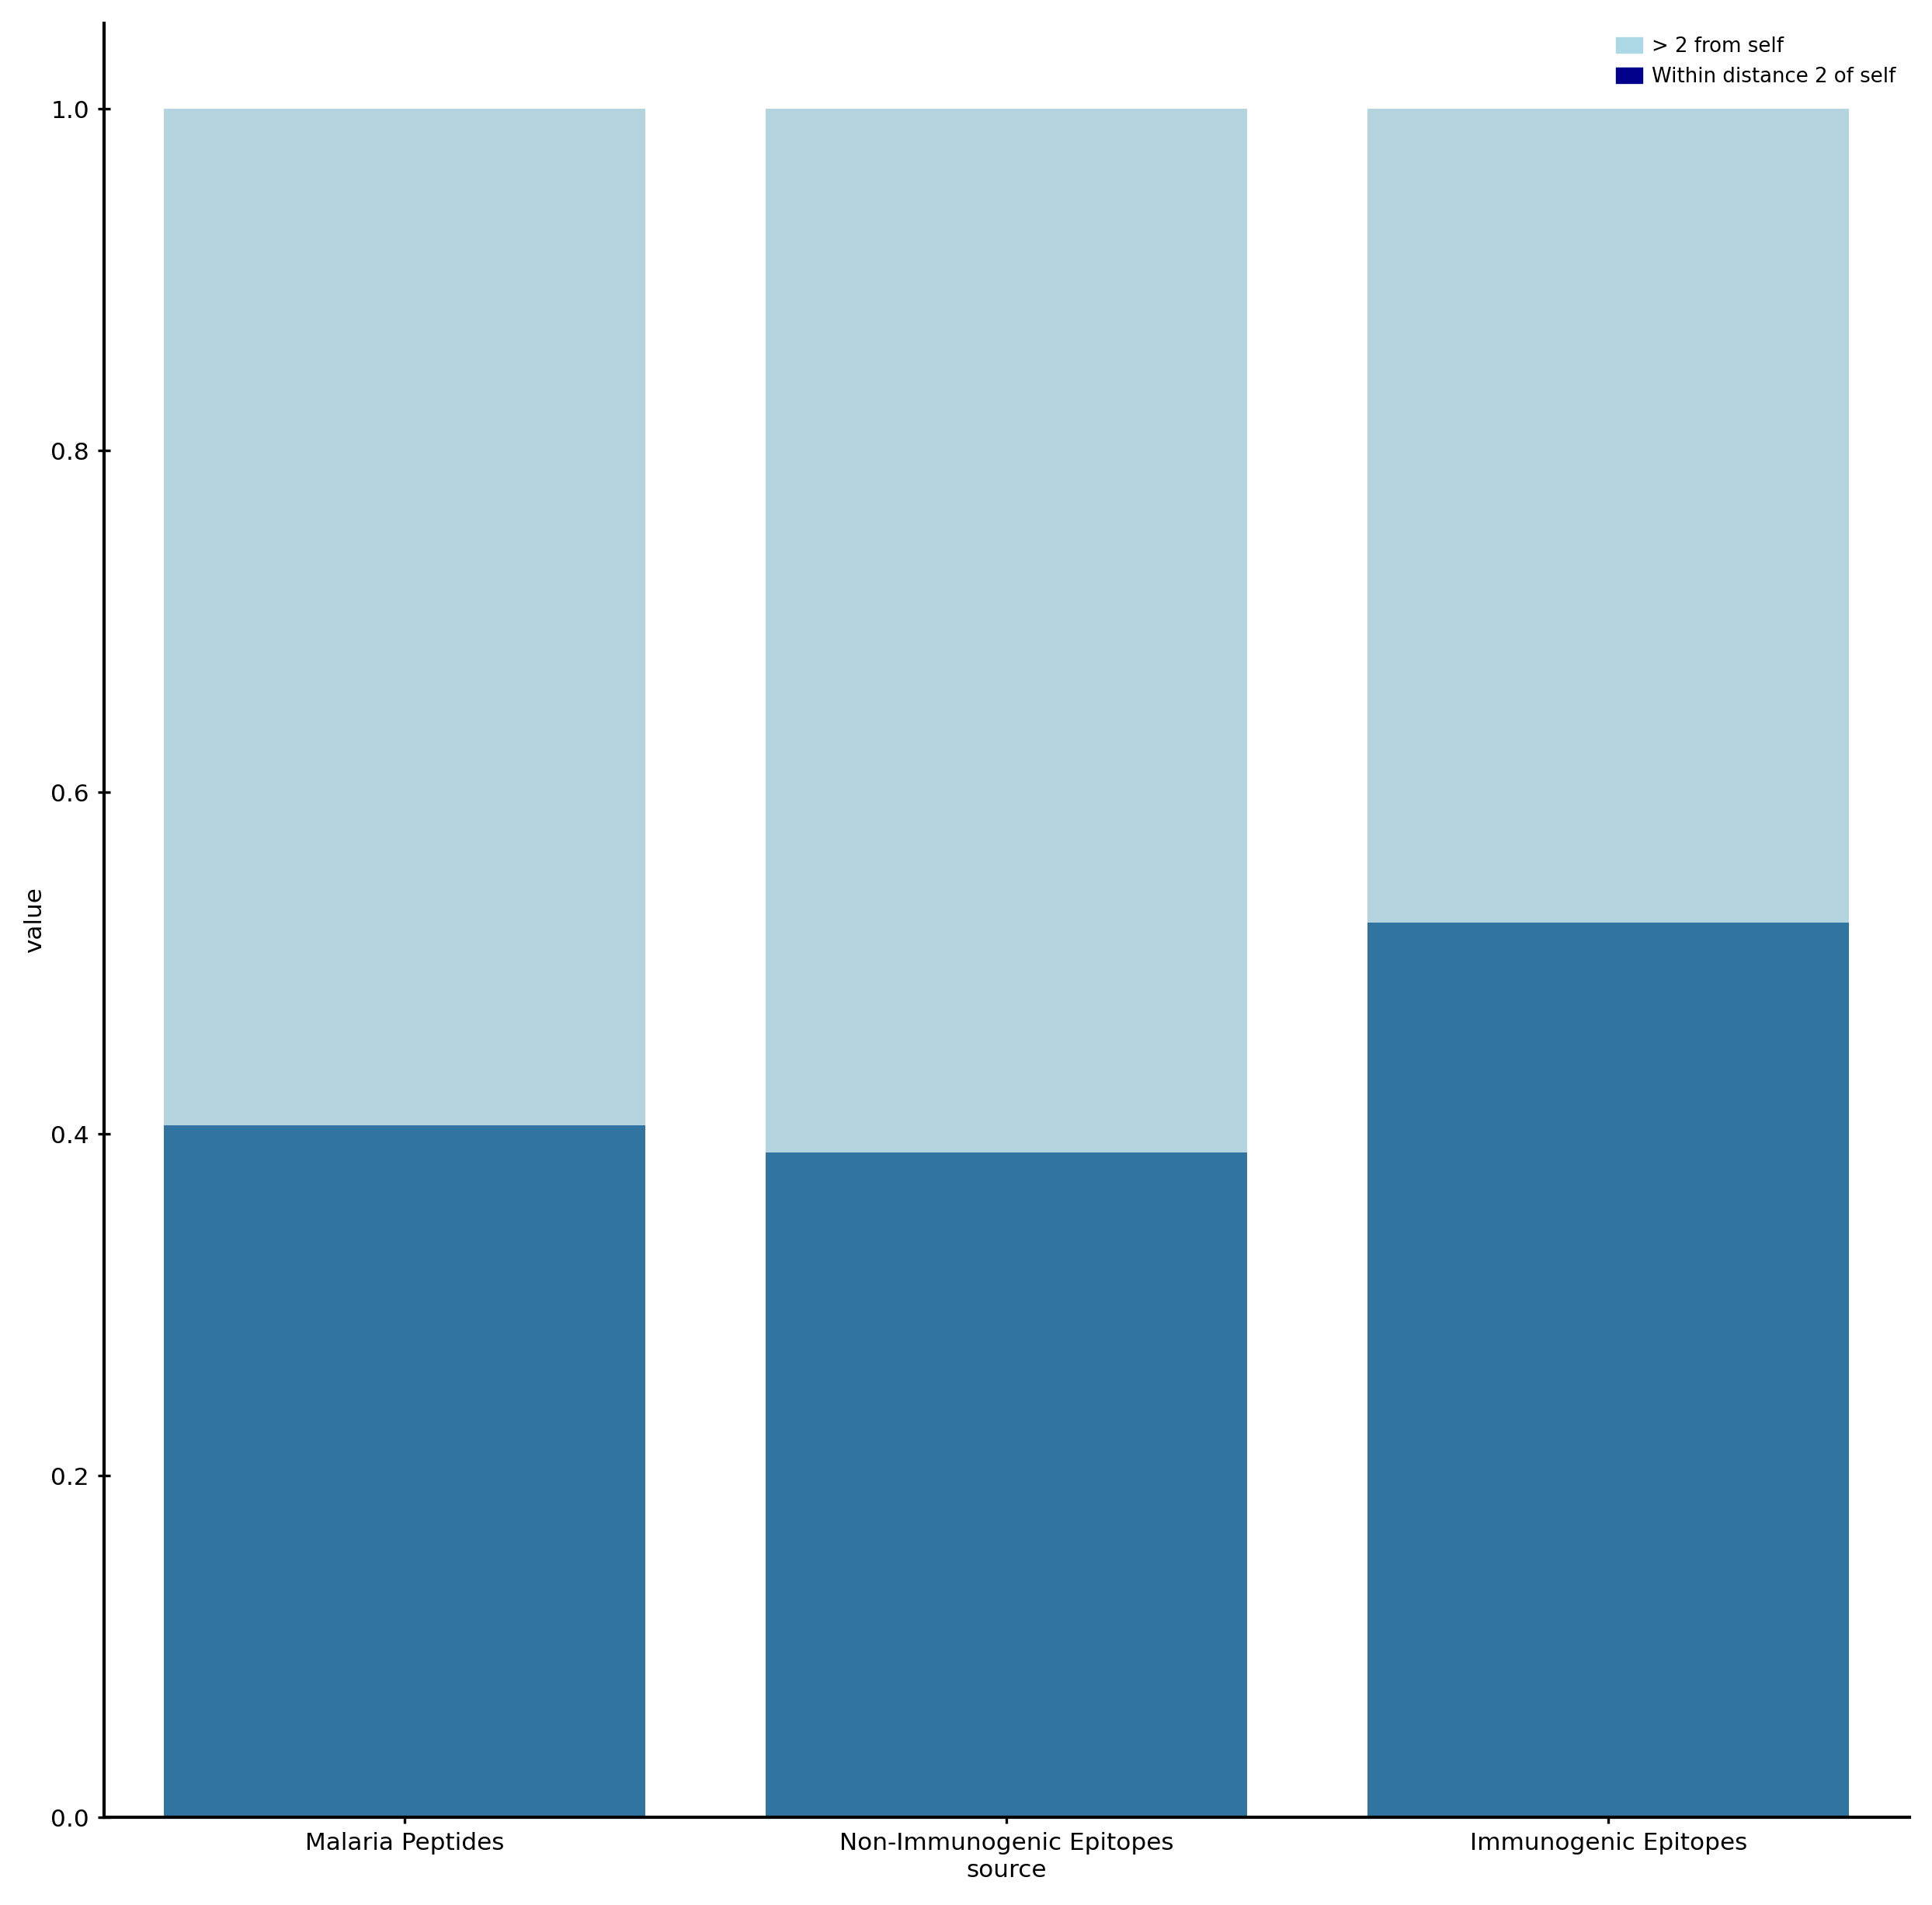

In [25]:
plt.figure(figsize=(10,10))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="source",  y="value", data=total_df, color='lightblue',order=list(source_mapper.values()))

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="source", y="value", data=collapsed_df[collapsed_df['distance']=='<=2'], color='#1f77b4',order=list(source_mapper.values()))

# add legend
bottom_bar = mpatches.Patch(color='darkblue', label='Within distance 2 of self')
top_bar = mpatches.Patch(color='lightblue', label='> 2 from self')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [26]:
# full data for statistical test
with open(f'{datadir}/malaria_distance_to_self.json','r') as f:
    full_distances_data = json.load(f)

In [27]:
full_distances_data

{'malaria': [325, 2236, 37932, 59507],
 'epitopes': [0, 3, 28, 28],
 'epitope_source': [0, 129, 2100, 1831],
 'epitope_elispot': [0, 1, 21, 20],
 'epitope_source_elispot': [0, 127, 2011, 1785],
 'null': [1, 365, 18931, 80703],
 'epitope_negative': [0, 4, 16, 36],
 'epitope_negative_elispot': [0, 2, 12, 22]}

In [28]:
test_p = []
test_n = []
for source in ['malaria', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)

test_p = []
test_n = []
for source in ['epitope_negative', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


test_p = []
test_n = []
for source in ['epitope_negative', 'malaria']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


0.02972522107621781
0.034713167589419294
0.23321304185523178


In [29]:
test_p = []
test_n = []
for source in ['malaria', 'epitope_elispot']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)

test_p = []
test_n = []
for source in ['epitope_negative_elispot', 'epitope_elispot']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


test_p = []
test_n = []
for source in ['epitope_negative_elispot', 'malaria']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


0.05830922962993569
0.11671165488848478
0.4222912256967833


In [30]:
source_mapper = {
    'malaria': 'Malaria Peptides',
    'epitope_negative': 'Non-Immunogenic Epitopes',
    'epitopes': 'Immunogenic Epitopes',

}
rows = []
total_rows = []

for source in ['malaria', 'epitope_negative', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    
    rows.append({
        'source': source_mapper[source],
        'value': p
        
    })
    total_rows.append({
        'source': source_mapper[source],
        'value': 1
        
    })
close_to_self_df = pd.DataFrame(data=rows)
total_df = pd.DataFrame(data=total_rows)

In [31]:
close_to_self_df

,source,value
0,Malaria Peptides,0.404930
1,Non-Immunogenic Epitopes,0.357143
2,Immunogenic Epitopes,0.525424


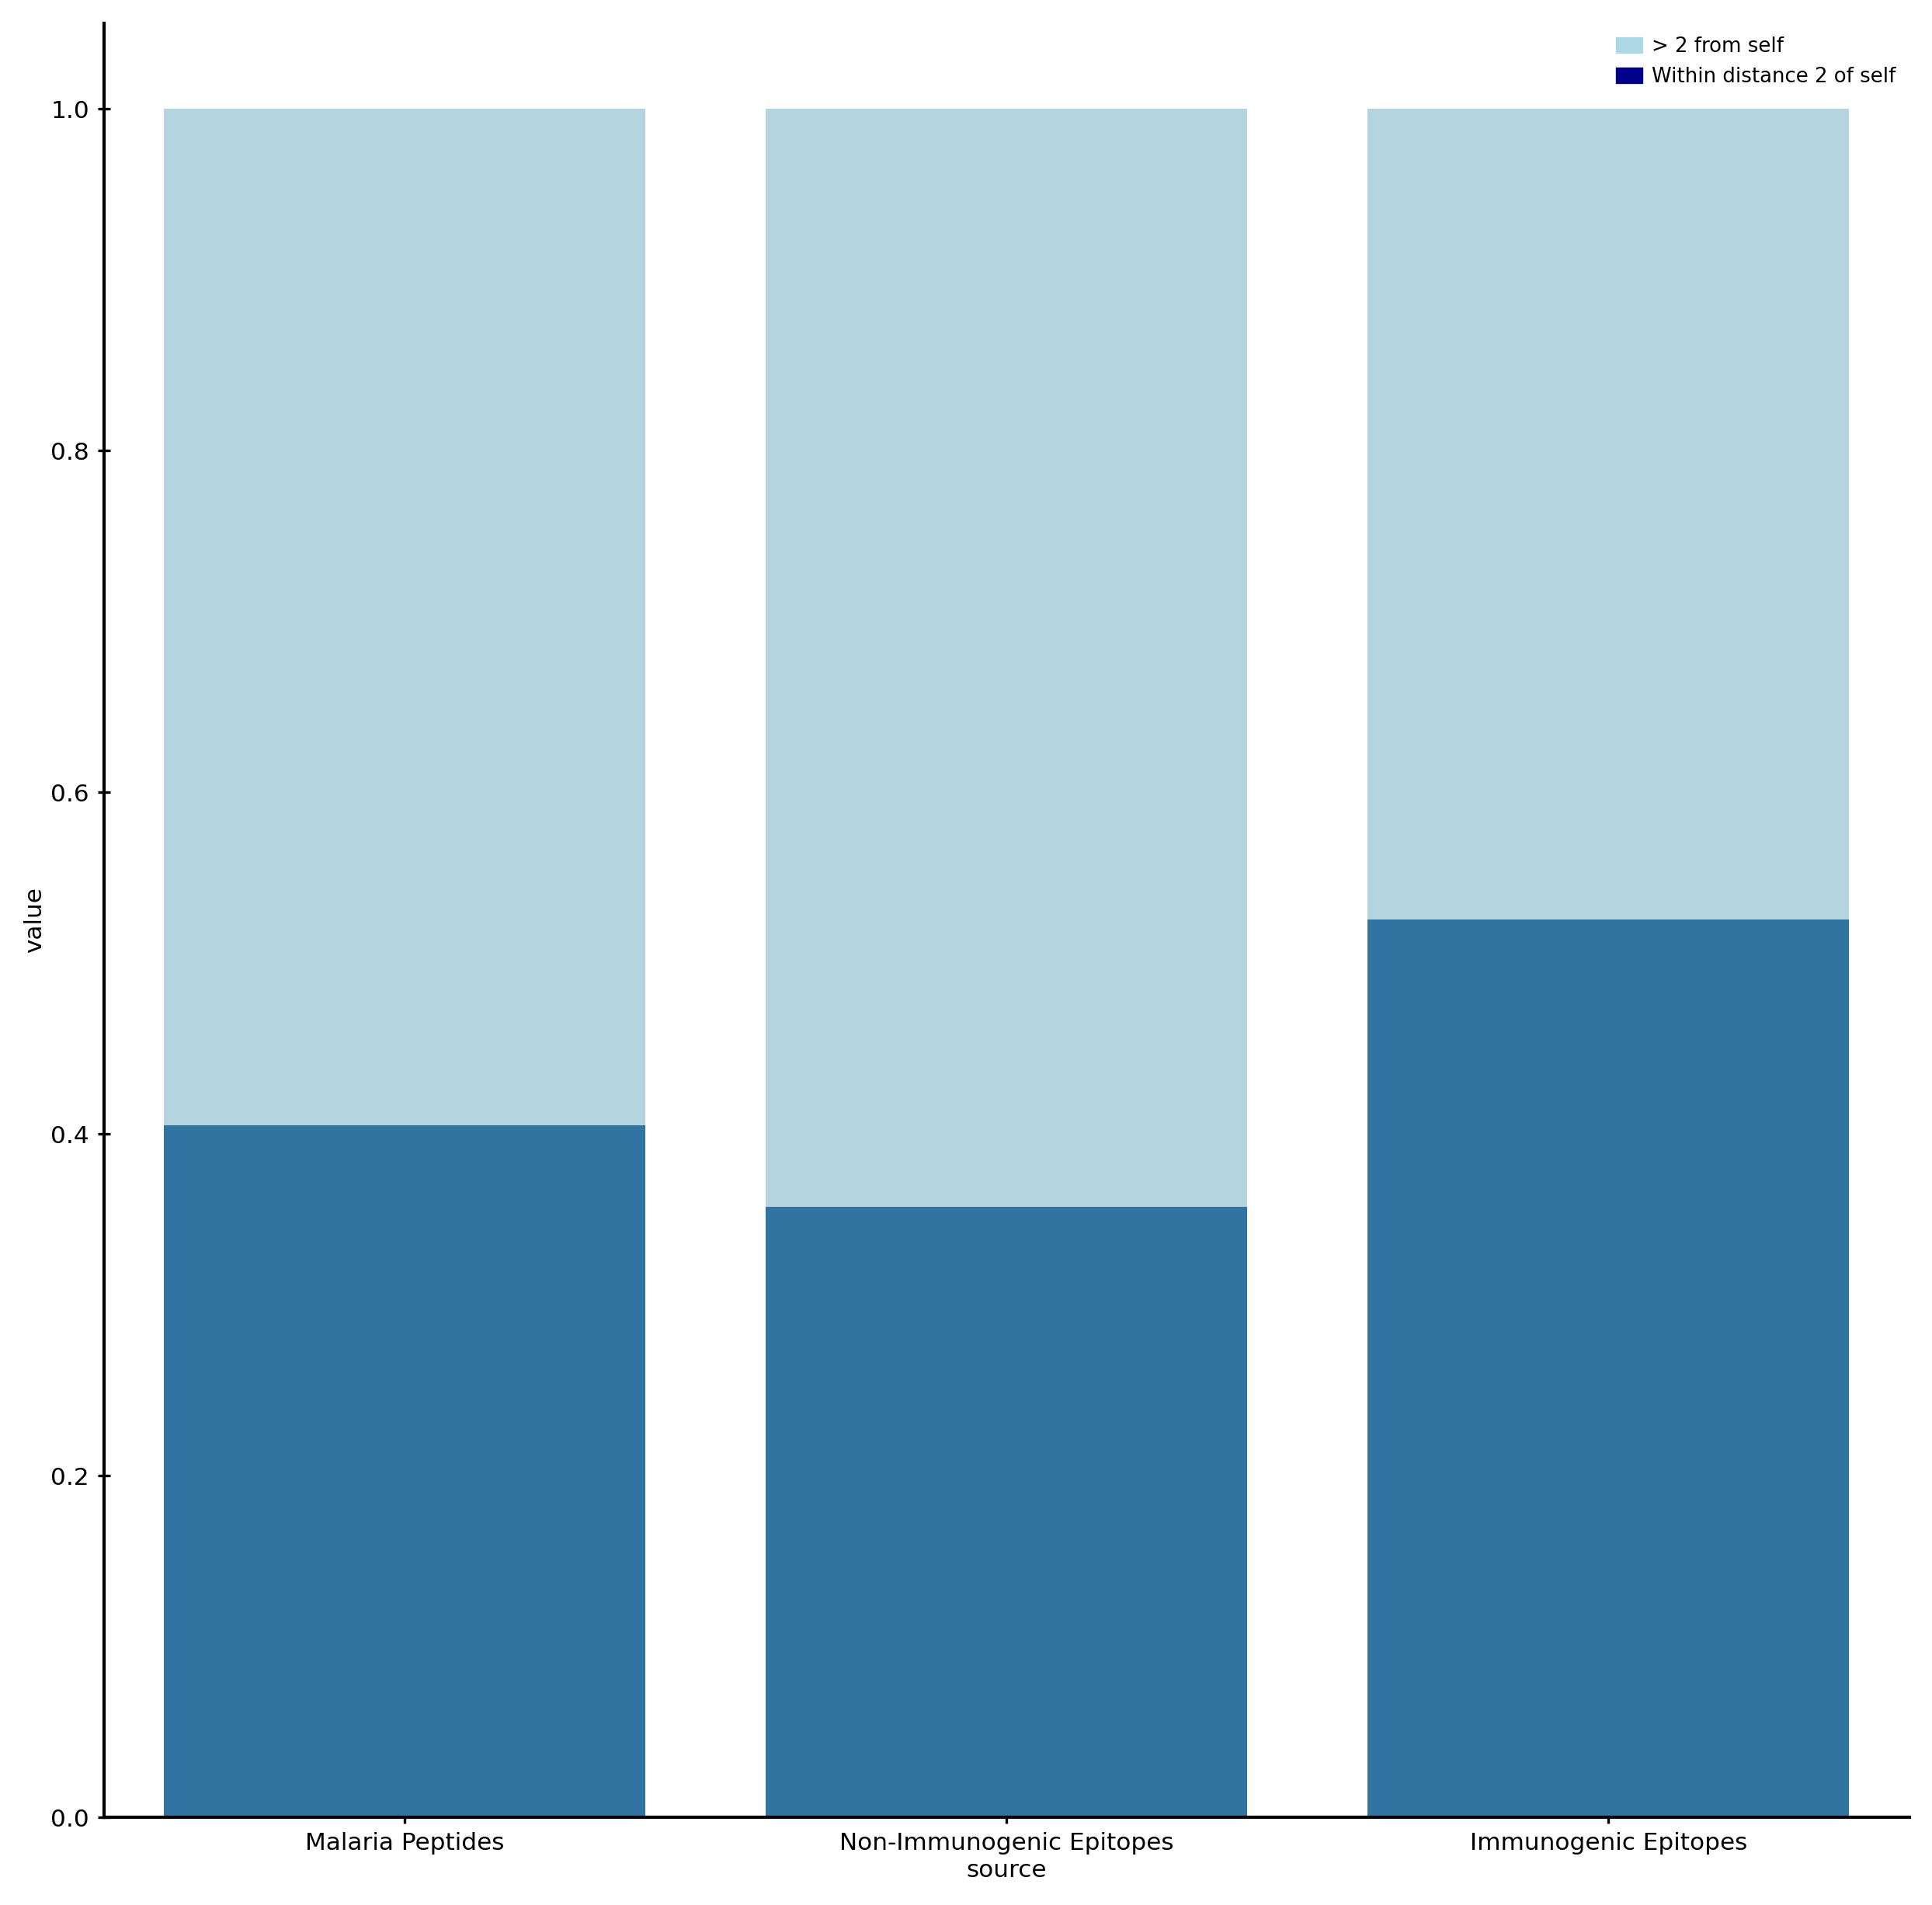

In [32]:
# not just ELISPOT


plt.figure(figsize=(10,10))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="source",  y="value", data=total_df, color='lightblue',order=list(source_mapper.values()))

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="source", y="value", data=close_to_self_df, color='#1f77b4',order=list(source_mapper.values()))

# add legend
bottom_bar = mpatches.Patch(color='darkblue', label='Within distance 2 of self')
top_bar = mpatches.Patch(color='lightblue', label='> 2 from self')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

#### Cross-Reactivity Distance For Epitopes at Distance=1

In [33]:
epidist_df = pd.read_csv(f'{figdatadir}/epidist.csv',index_col='Epitope')

In [34]:
epidist_df

,Unnamed: 0,Immunogenic,nndist,distance
Epitope,,,,
AAAPVVESK,1,False,1,7.286114
AEFTVPKFL,21,False,1,1.715035
AEMLREEGY,30,True,1,1.101286
AESRKLLLI,37,True,1,9.362759
AKLDRLDEE,91,True,1,5.315721
...,...,...,...,...
YFIKHVLAF,5751,False,1,4.946858
YFKRLTSEI,5755,False,1,8.972305
YLFNAIETM,5832,False,1,0.625489


In [35]:
epidist_df.groupby(by=['Immunogenic']).max()

,Unnamed: 0,nndist,distance
Immunogenic,,,
False,6036,1,14.528155
True,5357,1,15.199967


KstestResult(statistic=np.float64(0.32775768535262206), pvalue=np.float64(0.01748919047183408), statistic_location=np.float64(4.333440028399616), statistic_sign=np.int8(-1))

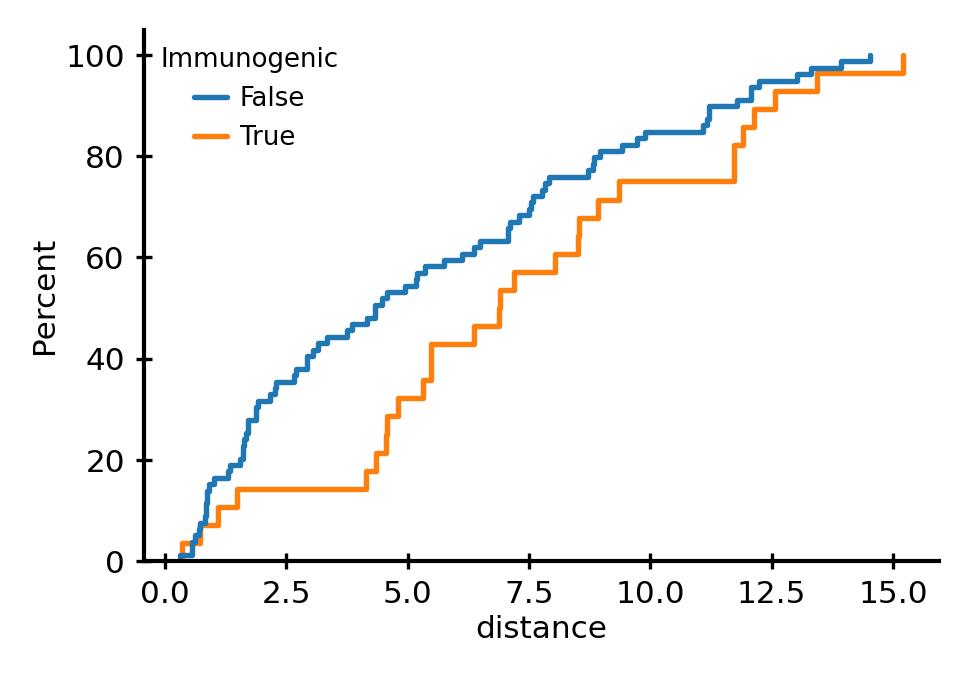

In [36]:
sns.ecdfplot(epidist_df,x="distance",hue='Immunogenic',stat='percent',complementary=False)
pos = epidist_df[epidist_df['Immunogenic']]['distance']
neg = epidist_df[~epidist_df['Immunogenic']]['distance']
scipy.stats.ks_2samp(pos,neg)

In [37]:
from matplotlib.table import Table
columns = ["Self Peptide", "P. Falciparum Epitope", "Cross-Reactivity Distance"]
data = [
    ["GAAGGLALL", "GIAGGLALL", "4.1"],
    ["VLAGLLGMV", "VLAGLLGNV", "6.1"],
    ["LGILSVSSF", "LAILSVSSF", "3.2"],
]

#### Malaria Protein Abundance Analysis

In [38]:
malaria_abundance_df = pd.read_csv(f'{figdatadir}/malaria_abundance.csv')

In [39]:
source_mapper = {
    'background': 'Malaria Peptides',
    'negative': 'Non-Immunogenic Epitopes',
    'positive': 'Immunogenic Epitopes',

}
malaria_abundance_df['source'] = malaria_abundance_df['source'].apply(source_mapper.get)

#### IEDB Model analysis


In [4]:
pos = np.load(f'{figdatadir}/iedb_pos_likelihood.npy')
neg = np.load(f'{figdatadir}/iedb_neg_likelihood.npy')

In [6]:
from scipy.stats import ks_2samp, mannwhitneyu

In [7]:
ks_2samp(pos,neg)

KstestResult(statistic=np.float64(0.10240125282756221), pvalue=np.float64(1.8491780418364488e-11), statistic_location=np.float64(-11.320676126383027), statistic_sign=np.int8(-1))

In [8]:
mannwhitneyu(pos,neg)

MannwhitneyuResult(statistic=np.float64(4358711.0), pvalue=np.float64(6.012039154504202e-11))

In [41]:
with open(f'{figdatadir}/iedb_pdf.json','r') as ff:
    iedb_density_dict = json.load(ff)

In [42]:
iedb_density_dict.keys()

dict_keys(['Human proteins', 'IEDB$^+$ T cell epitopes', 'IEDB$^-$ T cell epitopes'])

In [43]:
iedb_label_dict = {
    'Human proteins': 'Human Peptides',
    'IEDB$^+$ T cell epitopes': 'Immunogenic Peptides',
    'IEDB$^-$ T cell epitopes': 'Non-Immunogenic Peptides'
}

iedb_color_dict = {
    'IEDB$^+$ T cell epitopes': 'tab:orange',
    'IEDB$^-$ T cell epitopes': 'tab:blue'
}

## Put it all together for final figure

/tmp/ipykernel_2053143/1860816299.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)
/tmp/ipykernel_2053143/1860816299.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)


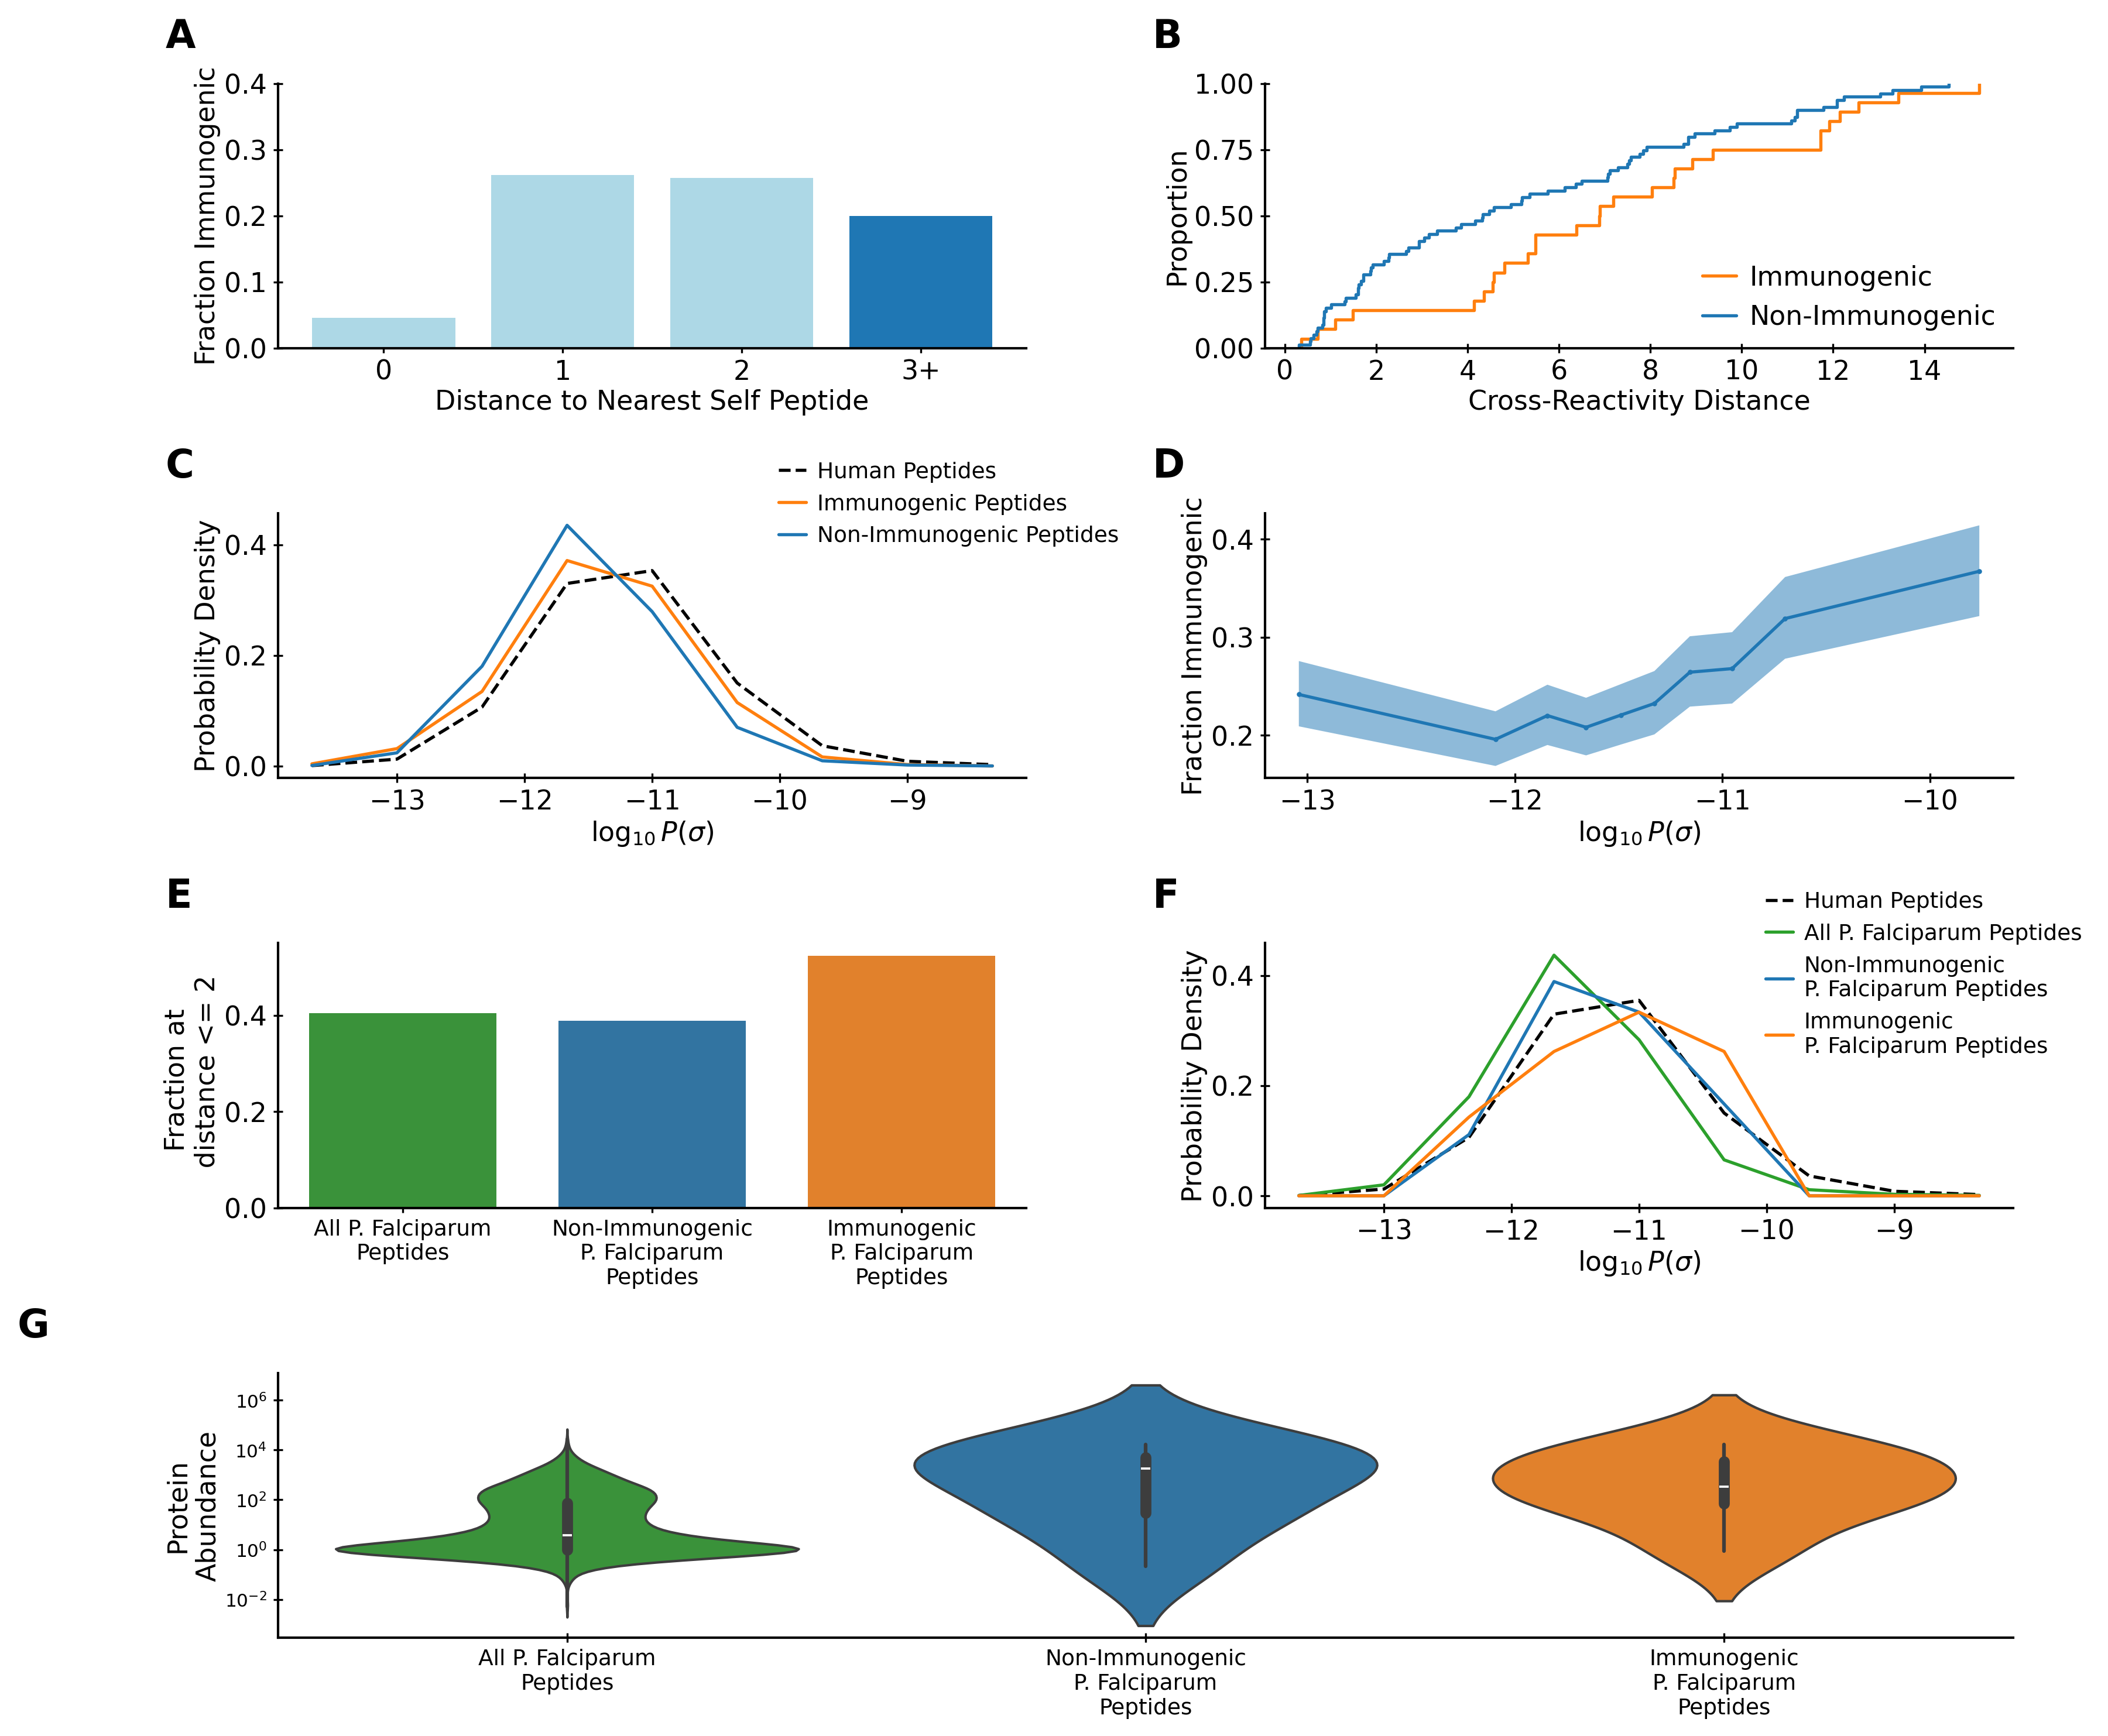

In [50]:
fig = plt.figure(figsize=(12, 10))

blue = '#1f77b4'
orange = '#ff7f0e'
green = '#2ca02c'

order_colors = {
 'Malaria Peptidome': green,
 'Malaria Epitopes (-)': blue,
 'Malaria Epitopes': orange
    
}
axfontsize = 11

# Define a GridSpec with 4 rows and 2 columns
gs = gridspec.GridSpec(4, 2)

# Create the first four subplots in a 2x2 grid
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
axL1 = fig.add_subplot(gs[1, 0])
axL2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])

# Create the fifth subplot, spanning both columns of the third row
ax5 = fig.add_subplot(gs[3, :])


ax1.bar(range(len(ps)), ps,color=['lightblue','lightblue','lightblue', blue])

ax1.set_ylim(0.0, 0.40)
ax1.set_xlabel('Distance to Nearest Self Peptide',fontsize=axfontsize)
ax1.set_ylabel('Fraction Immunogenic',fontsize=axfontsize)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels([0, 1, 2, '3+'],fontsize=axfontsize)
ax1.yaxis.set_tick_params(labelsize=axfontsize)



sns.ecdfplot(epidist_df,x="distance",hue='Immunogenic',ax=ax2,legend=False)

ax2.legend(loc='lower right', labels=['Immunogenic', 'Non-Immunogenic'],fontsize=axfontsize)
ax2.set_xlabel('Cross-Reactivity Distance',fontsize=axfontsize)
ax2.set_ylabel('Proportion',fontsize=axfontsize)
ax2.yaxis.set_tick_params(labelsize=axfontsize)
ax2.xaxis.set_tick_params(labelsize=axfontsize)


# xmin, xmax = np.quantile(likelihood_human, 0.01)-1, np.quantile(likelihood_human, 0.99)+1

# likelihood_vals = [likelihood_human, likelihood_immunogenic, likelihood_nonimmunogenic]
# labels = ['Human Peptides', 'Immunogenic Peptides', 'Non-Immunogenic Peptides']
# colors = ['k','tab:orange','tab:blue']
# styles = ['dotted','-','-']
# plot_likelihood_histograms(likelihood_vals, labels, xmin=xmin, xmax=xmax, ax=axL1, nbins=40,colors=colors,styles=styles)
# axL1.set_xlim(xmin, xmax)
# axL1.set_ylabel('Frequency',fontsize=axfontsize)
# axL1.set_xlabel('Human Model Log-Likelihood',fontsize=axfontsize)
# axL1.set_yscale('log')
# axL1.legend(loc='lower center',fontsize=axfontsize-3)
# axL1.yaxis.set_tick_params(labelsize=axfontsize)
# axL1.xaxis.set_tick_params(labelsize=axfontsize)

for dataset in iedb_density_dict:
    bins = np.array(iedb_density_dict[dataset]['bins'])
    pdf = np.array(iedb_density_dict[dataset]['pdf'])
# density
    if dataset.startswith('Human'):
        axL1.plot(0.5*(bins[:-1]+bins[1:]), pdf ,'k--',label=iedb_label_dict[dataset])
    else:
        axL1.plot(0.5*(bins[:-1]+bins[1:]), pdf ,color=iedb_color_dict[dataset], label=iedb_label_dict[dataset])

axL1.set_xlabel(r'$\log_{10} P(\sigma)$',fontsize=axfontsize)
axL1.xaxis.set_tick_params(labelsize=axfontsize)
axL1.yaxis.set_tick_params(labelsize=axfontsize)

axL1.set_ylabel('Probability Density',fontsize=axfontsize)
axL1.legend(loc='upper left',bbox_to_anchor=(0.65,1.25),fontsize=axfontsize-2)



# num_quantiles = 10

# bin_edges = np.quantile(likelihood_immunogenic, np.linspace(0, 1, num_quantiles + 1))
# binmids = (bin_edges[1:]+bin_edges[:-1])*0.5

# hist_pos_q, _ = np.histogram(likelihood_immunogenic, bins=bin_edges)
# hist_neg_q,_ = np.histogram(likelihood_nonimmunogenic, bins=bin_edges)

# plot_proportion(binmids,hist_pos_q, hist_pos_q+hist_neg_q, ls='-', marker='.', ax=axL2)
# axL2.set_xlabel('Human Model Log-Likelihood',fontsize=axfontsize)
# axL2.set_ylabel('Fraction Immunogenic',fontsize=axfontsize)
# axL2.yaxis.set_tick_params(labelsize=axfontsize)
# axL2.xaxis.set_tick_params(labelsize=axfontsize)

num_quantiles = 10

bin_edges = np.quantile(pos, np.linspace(0, 1, num_quantiles + 1))
binmids = (bin_edges[1:]+bin_edges[:-1])*0.5

hist_pos_q, _ = np.histogram(pos, bins=bin_edges)
hist_neg_q,_ = np.histogram(neg, bins=bin_edges)

plot_proportion(binmids,hist_pos_q, hist_pos_q+hist_neg_q, ls='-', marker='.', ax=axL2)
axL2.set_xlabel(r'$\log_{10} P(\sigma)$',fontsize=axfontsize)
axL2.set_ylabel('Fraction Immunogenic',fontsize=axfontsize)
axL2.xaxis.set_tick_params(labelsize=axfontsize)
axL2.yaxis.set_tick_params(labelsize=axfontsize)
axL2.xaxis.set_major_locator(MaxNLocator(integer=True))

labels_dict = {
    'Human Peptidome': 'Human Peptides',
    'Malaria Peptidome': 'All P. Falciparum Peptides',
    'Malaria Epitopes': 'Immunogenic\nP. Falciparum Peptides',
    'Malaria Epitopes (-)': 'Non-Immunogenic\nP. Falciparum Peptides'
}

for dataset in order:
    bins = np.array(density_dict[dataset]['bins'])
    pdf = np.array(density_dict[dataset]['pdf'])
# density
    if dataset.startswith('Human'):
        ax4.plot(0.5*(bins[:-1]+bins[1:]), pdf ,'k--',label=labels_dict[dataset])
    else:
        ax4.plot(0.5*(bins[:-1]+bins[1:]), pdf ,color=order_colors[dataset],label=labels_dict[dataset])

ax4.set_xlabel(r'$\log_{10} P(\sigma)$',fontsize=axfontsize)
ax4.xaxis.set_tick_params(labelsize=axfontsize)
ax4.yaxis.set_tick_params(labelsize=axfontsize)

ax4.set_ylabel('Probability Density',fontsize=axfontsize)
ax4.legend(loc='upper left',bbox_to_anchor=(0.65,1.25),fontsize=axfontsize-2)

# sns.boxplot(abundance_results,x='source',y='value',log_scale=True)

# bar1 = sns.barplot(x="source",  y="value", width=.75,data=total_df, color='lightblue',order=list(source_mapper.values()),ax=ax3)
bar2 = sns.barplot(x="source", y="value", width=.75,
                   data=collapsed_df[collapsed_df['distance']=='<=2'],
                   hue_order=['Non-Immunogenic Epitopes', 'Immunogenic Epitopes', 'Malaria Peptides'],
                   hue="source",legend=False,order=list(source_mapper.values()),ax=ax3)

# add legend
# bottom_bar = mpatches.Patch(color='darkblue', label='dist <= 2')
# top_bar = mpatches.Patch(color='lightblue', label='dist > 2')
# ax3.legend(loc='center left',
#                bbox_to_anchor=(-.5,.75),
#                handles=[top_bar, bottom_bar],
#                title='Distance to Nearest\n    Self Peptide\n',
#                fontsize=axfontsize,
#                title_fontproperties={'weight': 'bold','size': 'small'},
#               frameon=False)
ax3.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)

ax3.set_xlabel('')
ax3.set_ylabel('Fraction at \n distance <= 2',fontsize=axfontsize)
# axes[1].legend(loc='upper right',bbox_to_anchor=(.5,1.55))

ax3.yaxis.set_tick_params(labelsize=axfontsize)

sns.violinplot(data=malaria_abundance_df, x='source',
               y='value', ax=ax5,hue='source',
               legend=False,log_scale=True,
               hue_order=['Immunogenic Epitopes', 'Non-Immunogenic Epitopes', 'Malaria Peptides'])
# sns.boxplot(data=malaria_abundance_df, x='source', y='value', color='white', showfliers=False, whis=0, ax=ax4,log_scale=True)
ax5.set_xlabel('')
ax5.set_ylabel('Protein\nAbundance',fontsize=axfontsize)
ax5.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)


# ax6.set_axis_off()  # Turn off the axis

# # Create the table
# table = Table(ax6, bbox=[0, 0, 1, 1])
# table.FONTSIZE=24
# for col_idx, col_name in enumerate(columns):
#     table.add_cell(0, col_idx, width=0.2, height=0.2, text=col_name, loc='center', facecolor='lightgray')

# for row_idx, row_data in enumerate(data, start=1):
#     for col_idx, cell_data in enumerate(row_data):
#         table.add_cell(row_idx, col_idx, width=0.2, height=0.2, text=cell_data, loc='center', facecolor='white')

# ax6.add_table(table)


label_axes(fig,labelstyle='%s', xy=(-0.15, 1.25),fontsize=16)
fig.tight_layout(h_pad=.5)
plt.savefig('../fig4_final.pdf')
# plt.savefig('../fig4_updated.svg')


In [45]:
bins

array([-14.        , -13.33333333, -12.66666667, -12.        ,
       -11.33333333, -10.66666667, -10.        ,  -9.33333333,
        -8.66666667,  -8.        ])

In [46]:
m_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Malaria Peptides']['value']
p_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Non-Immunogenic Epitopes']['value']
n_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Immunogenic Epitopes']['value']


In [47]:
scipy.stats.mannwhitneyu(np.array(m_abundance), np.array(p_abundance))

MannwhitneyuResult(statistic=np.float64(7180.5), pvalue=np.float64(0.006965592217913208))

In [48]:
scipy.stats.mannwhitneyu(np.array(m_abundance), np.array(n_abundance))

MannwhitneyuResult(statistic=np.float64(8306.5), pvalue=np.float64(0.016233260124247025))

In [49]:
scipy.stats.mannwhitneyu(np.array(p_abundance), np.array(n_abundance))

MannwhitneyuResult(statistic=np.float64(25.0), pvalue=np.float64(1.0))